In [ ]:
import os
os.getcwd()
os.listdir()

['.config', 'sample_data']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,r2_score
from sklearn.metrics import precision_score,recall_score 
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('train.csv')
X_features = df.copy()
'''
features = ['Age','Gender','Education_Duration','Housing','Loan Status',
            'Working_Hours','Investment','Loan','Dependents','Marital_Status',
            'Employer_Kind','Income','Debt_Paid','Yearly_Breaks','Answer']
X_features = X_features[features]

test_features = ['Age','Gender','Education_Duration','Housing','Loan Status',
            'Working_Hours','Investment','Loan','Dependents','Marital_Status',
            'Employer_Kind','Income','Debt_Paid','Yearly_Breaks']
'''
df_test = pd.read_csv('test.csv')
user_id = df_test.Id.values
X_test = df_test.copy()

print(X_features.columns,X_test.columns)

Index(['Age', 'SSec_Category', 'Gender', 'Hobby', 'Education_Duration',
       'Housing', 'Profession', 'Loan Status', 'Working_Hours', 'Investment',
       'Loan', 'Dependents', 'Marital_Status', 'Yearly_Breaks',
       'Number_of_Siblings', 'Employer_Kind', 'City', 'Income', 'Answer',
       'Country', 'Debt_Paid', 'Id'],
      dtype='object') Index(['Age', 'SSec_Category', 'Gender', 'Hobby', 'Education_Duration',
       'Housing', 'Profession', 'Loan Status', 'Working_Hours', 'Investment',
       'Loan', 'Dependents', 'Marital_Status', 'Yearly_Breaks',
       'Number_of_Siblings', 'Employer_Kind', 'City', 'Income', 'Country',
       'Debt_Paid', 'Id'],
      dtype='object')


In [ ]:
corr_mat = df.corr()
cor_target = abs(corr_mat['Answer'])
selected_features = cor_target[cor_target > 0.01]
selected_features

Age                   0.231185
SSec_Category         0.071286
Hobby                 0.080234
Education_Duration    0.333579
Profession            0.032068
Working_Hours         0.231490
Investment            0.222582
Loan                  0.155595
Dependents            0.254639
City                  0.019552
Answer                1.000000
Name: Answer, dtype: float64

In [ ]:
correlated_features = ['Age','SSec_Category','Hobby','Education_Duration','Profession','Working_Hours',
                       'Investment','Loan','Dependents','City','Answer']
X_correlated = df.copy()
X_correlated = X_correlated[correlated_features]
X_correlated.head()

,Age,SSec_Category,Hobby,Education_Duration,Profession,Working_Hours,Investment,Loan,Dependents,City,Answer
0,37.0,4,9,14.0,0,NaN,2194.0,2000.0,2,38,0
1,48.0,4,9,14.0,3,15.0,20.0,2000.0,1,38,0
2,36.0,4,11,10.0,5,42.0,20.0,2000.0,2,38,0
3,51.0,2,1,8.0,5,42.0,20.0,2000.0,1,38,0
4,26.0,2,9,14.0,9,42.0,20.0,2000.0,6,4,0


In [ ]:
correlated_features_test = ['Age','SSec_Category','Hobby','Education_Duration','Profession','Working_Hours',
                       'Investment','Loan','Dependents','City']
X_correlated_test = df_test.copy()
X_correlated_test = X_correlated_test[correlated_features_test]
X_correlated_test.head()

,Age,SSec_Category,Hobby,Education_Duration,Profession,Working_Hours,Investment,Loan,Dependents,City
0,47.0,2,6,6.0,7,18.0,20.0,2000.0,2,22
1,28.0,1,9,14.0,9,42.0,20.0,2000.0,1,18
2,52.0,2,11,10.0,7,NaN,20.0,2000.0,5,38
3,41.0,4,1,8.0,13,42.0,20.0,4042.0,1,38
4,52.0,1,15,11.0,9,62.0,20.0,2000.0,1,34


In [ ]:
X_features = X_features.select_dtypes(exclude=['object'])
X_test = X_test.select_dtypes(exclude=['object'])
print(X_features.shape,X_test.shape)

'''
#try label encoding the categorical columns
s = (X_features.dtypes == 'object')
object_cols = list(s[s].index)
print(object_cols)
'''

(34308, 6) (14537, 6)


"\n#try label encoding the categorical columns\ns = (X_features.dtypes == 'object')\nobject_cols = list(s[s].index)\nprint(object_cols)\n"

In [ ]:
y = df.Answer
X_train, X_valid, y_train, y_valid = train_test_split(X_features, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [ ]:
class CustomImputer(TransformerMixin):
    def __init__(self):
        '''
        Replace numerical,float missing values to mean values.
        Replace categorical missing values to most frequent
        '''
    def fit(self,X,y=None):
        self.impute_values = pd.Series([X[cols].value_counts().index[0]
                                        if X[cols].dtype == np.dtype('O') else X[cols].mean() for cols in X],
                                        index = X.columns
                                        )
        return self
    
    def transform(self,X,y=None):
        return X.fillna(self.impute_values)    


In [ ]:
imputer_obj = CustomImputer()
imputer_obj.fit(X_train)
X_train_Imputed = imputer_obj.transform(X_train)
X_valid_Imputed = imputer_obj.transform(X_valid)
X_test_Imputed = imputer_obj.transform(X_test)

X_features_Imputed = imputer_obj.fit_transform(X_features)


In [ ]:
#X_test_Imputed['Housing'].replace({'Treehouse':'Condo'},inplace = True)
X_train_Imputed.head()

,Age,Education_Duration,Working_Hours,Investment,Loan,Dependents
9683,18.0,11.0,42.0,20.0,2000.0,4
18682,56.0,10.0,42.0,20.0,2000.0,2
18908,32.0,10.0,42.0,20.0,2000.0,4
23131,17.0,10.0,42.0,20.0,2000.0,5
14821,20.0,14.0,42.0,20.0,2000.0,4


In [ ]:
#X_valid_Imputed['Employer_Kind'].replace({'Startup':'Self-employed'},inplace = True)


In [ ]:
'''
#try label encoding
label_X_train = X_train_Imputed.copy()
label_X_valid = X_valid_Imputed.copy()
label_X_test = X_test_Imputed.copy()

label_encoder = LabelEncoder()

for cols in object_cols:
     label_X_train[cols] = label_encoder.fit_transform(X_train_Imputed[cols])
    label_X_valid[cols] = label_encoder.transform(X_valid_Imputed[cols])
    label_X_test[cols] = label_encoder.transform(X_test_Imputed[cols])
'''

In [ ]:
#try Standard Scaling
#X_features_Norm = X_features_Imputed.copy()
X_train_Norm = X_train_Imputed.copy()
X_valid_Norm = X_valid_Imputed.copy()
X_test_Norm = X_test_Imputed.copy()

s = (X_train_Imputed.dtypes !='Object')
num_cols = list(s[s].index)
print(num_cols)


['Age', 'Education_Duration', 'Working_Hours', 'Investment', 'Loan', 'Dependents', 'Income', 'Debt_Paid']


In [ ]:

from sklearn.preprocessing import MinMaxScaler,StandardScaler
norm = StandardScaler()
#X_features_Norm[num_cols] = norm.fit_transform(X_features_Norm[num_cols])
X_train_Norm[num_cols] = norm.fit_transform(X_train_Norm[num_cols])
X_valid_Norm[num_cols] = norm.transform(X_valid_Norm[num_cols])
X_test_Norm[num_cols] = norm.transform(X_test_Norm[num_cols])


In [ ]:
from pprint import pprint
rf = RandomForestClassifier(random_state=42)
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start =100, stop =1000 , num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 20, 25, 30]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 6, 8, 10]

# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid

random_grid = {
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
               }
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [2, 4, 6, 8, 10],
 'min_samples_split': [5, 10, 15, 20, 25, 30],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [ ]:
y = df['Answer']

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, 
                               cv = 3, verbose=2, random_state=42)

rf_random.fit(X_features_Imputed,y)

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 200}

In [ ]:
#try PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95) #I wish to preserve 0.95 variance
X_train_reduced = pca.fit_transform(X_train_Norm)
X_valid_reduced = pca.transform(X_valid_Norm)
X_test_reduced = pca.transform(X_test_Norm)


In [ ]:
model = RandomForestClassifier(n_estimators=200,max_depth=90,max_features='auto',min_samples_leaf=10,min_samples_split=10,bootstrap=True,n_jobs=-1)
model.fit(X_train_Imputed,y_train)
compare_y_valid = model.predict(X_valid_Imputed)
print(accuracy_score(y_valid,compare_y_valid))
#0.8590789857184494

0.8582046050714077


In [ ]:
compare_y_valid

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
pip install pycaret

In [ ]:
pip install shap

In [ ]:
from pycaret import classification

In [ ]:
classification.setup(data = X_correlated,target = 'Answer')

In [ ]:
classification.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8702,0.9233,0.6398,0.7781,0.7022,0.6202,0.6251,0.323
xgboost,Extreme Gradient Boosting,0.8692,0.9218,0.6419,0.7729,0.7012,0.6184,0.6229,7.275
catboost,CatBoost Classifier,0.8692,0.9234,0.6337,0.7783,0.6986,0.6162,0.6215,11.944
gbc,Gradient Boosting Classifier,0.8644,0.9181,0.5913,0.7890,0.6759,0.5924,0.6023,2.449
ada,Ada Boost Classifier,0.8598,0.9124,0.5987,0.7637,0.6712,0.5837,0.5907,0.752
lr,Logistic Regression,0.8474,0.8952,0.5756,0.7294,0.6430,0.5478,0.5542,4.231
rf,Random Forest Classifier,0.8417,0.8834,0.6130,0.6904,0.6493,0.5475,0.5492,2.423
knn,K Neighbors Classifier,0.8404,0.8650,0.6064,0.6891,0.6451,0.5427,0.5446,3.121
lda,Linear Discriminant Analysis,0.8401,0.8883,0.5455,0.7186,0.6200,0.5212,0.5292,0.189
ridge,Ridge Classifier,0.8394,0.0000,0.4918,0.7505,0.5940,0.4993,0.5167,0.048


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=6007, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
#built the model
classification_model = classification.create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8843,0.9293,0.6655,0.8162,0.7332,0.6603,0.6659
1,0.8651,0.9160,0.6411,0.7572,0.6943,0.6086,0.6120
2,0.8659,0.9150,0.6376,0.7625,0.6945,0.6095,0.6135
3,0.8768,0.9307,0.6574,0.7925,0.7186,0.6406,0.6452
4,0.8643,0.9164,0.6365,0.7578,0.6919,0.6057,0.6095
5,0.8626,0.9184,0.6132,0.7652,0.6809,0.5946,0.6005
6,0.8709,0.9261,0.6463,0.7762,0.7053,0.6235,0.6278
7,0.8709,0.9229,0.6289,0.7882,0.6996,0.6187,0.6251
8,0.8692,0.9257,0.6341,0.7778,0.6987,0.6162,0.6215
9,0.8721,0.9324,0.6376,0.7871,0.7045,0.6241,0.6297


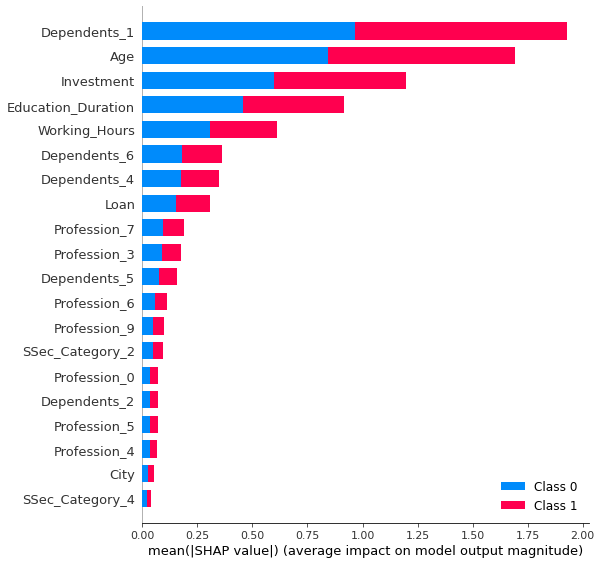

In [ ]:
#interpret the model
classification.interpret_model(classification_model)

In [ ]:
predictions = classification.predict_model(classification_model,data=X_test)

In [ ]:
y_predicted = predictions['Label']

In [ ]:
submission_df = pd.DataFrame({'Id':user_id,'Answer':y_predicted})
submission_df.set_index('Id',inplace=True)
len(submission_df)

14537

In [ ]:
submission_df.to_csv('submission.csv')

In [ ]:
to_submit = pd.read_csv('submission5.csv')
to_submit.head()

,Unnamed: 0,Id,Answer
0,0,6,0.0
1,1,11,0.0
2,2,21,0.0
3,3,23,0.0
4,4,27,0.0


In [ ]:
del to_submit['Unnamed: 0']
to_submit.set_index('Id',inplace=True)
to_submit.head()

,Answer
Id,
6,0.0
11,0.0
21,0.0
23,0.0
27,0.0


In [ ]:
to_submit.to_csv('submission.csv')